In [1]:
from __future__ import division
import math
import pickle
import requests
import numpy as np
import tensorflow as tf
from itertools import product
from random import sample
from string import lowercase, digits
# from captcha.image import ImageCaptcha

In [2]:
from StringIO import StringIO
import tempfile
from PIL import Image
import py4j
from py4j.java_gateway import JavaGateway, GatewayParameters

### .初始化验证生成控件

In [3]:
port = py4j.java_gateway.launch_gateway(classpath='/usr/lib/jvm/lib/kaptcha-2.3.2.jar')
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=port))
constants = gateway.jvm.com.google.code.kaptcha.Constants
ImageIO = gateway.jvm.javax.imageio.ImageIO
filename = tempfile.mktemp(suffix='.jpg')

In [4]:
fontSizeList = ['39', '40', '41', '42', '43', '44', '45']
fontNameList = [
    'Ubuntu Light',
    'Ubuntu Light Italic',
    'Ubuntu Regular',
    'Ubuntu Regular Italic',
    'Lato-Hairline',
    'lmroman8-italic', 
    'lmmonocaps10-regular',
    'Loma-Oblique',
    'Norasi-Oblique',
    'Umpush-Light',
]
kaptchaList = []
for fontSize, fontName in product(fontSizeList, fontNameList):
    properties = gateway.jvm.java.util.Properties()
    properties.put(constants.KAPTCHA_IMAGE_WIDTH, '223')
    properties.put(constants.KAPTCHA_IMAGE_HEIGHT, '50')
    properties.put(constants.KAPTCHA_TEXTPRODUCER_FONT_SIZE, fontSize)
    properties.put(constants.KAPTCHA_TEXTPRODUCER_FONT_NAMES, fontName)
    properties.put(constants.KAPTCHA_BORDER, 'no')
    kaptchaConfig = gateway.jvm.com.google.code.kaptcha.util.Config(properties)
    kaptcha = gateway.jvm.com.google.code.kaptcha.impl.DefaultKaptcha()
    kaptcha.setConfig(kaptchaConfig)
    kaptchaList.append(kaptcha)

### .定义模型参数

In [5]:
index = 1
width = 223
height = 50
# charset = '0123456789'
# charset = '0123456789' + lowercase
charset = digits + lowercase
# captchaLength = 4
captchaLength = 1
imageSize = width * height
alpha = 1e-3

### .定义相关函数

In [6]:
# def getCode():
#     return ''.join(map(
#         lambda x: charset[x], 
#         # np.random.randint(0, len(charset), captchaLength)  
#         np.random.randint(0, len(charset), 4) # changed
#     ))
# captcha = ImageCaptcha(width=width, height=height)

In [7]:
# def getData(n = 10):    
#     codeList = [getCode() for _ in range(n)]
#     imageList = map(lambda code: captcha.generate_image(code), codeList)
#     return imageList, codeList

In [8]:
def getCode():
    return kaptcha.createText()

In [9]:
def generateImage(code):
    kaptcha = sample(kaptchaList, 1)[0]
    image = kaptcha.createImage(code)
    f = gateway.jvm.java.io.File(filename)    
    ImageIO.write(image, 'JPG', f)
    image = Image.open(filename)
    return image

In [10]:
def getData(n = 10):    
    codeList = [getCode() for _ in range(n)]
    imageList = map(lambda code: generateImage(code), codeList)
    return imageList, codeList

In [11]:
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.01)                                                                                                     
    return tf.Variable(initial)   

In [12]:
def bias_variable(shape):
    initial = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(initial)   

In [13]:
def conv2d(x, W): 
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [14]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [15]:
# def imageToVertor(image):
#     """ 将图片转化为向量表示 """
#     image = image.convert("L")
#     image = np.asarray(image)
#     image = image.reshape([width * height]) / 255
#     return image

In [16]:
def imageToVertor(image):
    """ 将图片转化为向量表示 """
    width = image.width
    height = image.height
    image = image.convert("L")
    image = np.asarray(image)
    image = image.reshape([width * height]) / 255
    return image

In [17]:
def codeToVertor(code):
    """ 将验证码转化为向量表示 """
    labels = np.zeros([captchaLength, len(charset)])
    for i in range(captchaLength):
        labels[i, charset.index(code[i])] = 1
    return labels.reshape(len(charset) * captchaLength)

eyban


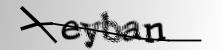

In [18]:
# 测试验证码
code = getCode()
print code
generateImage(code)

### .定义神经网络结构

In [19]:
# 定义输入输出
x = tf.placeholder(tf.float32, shape=[None, imageSize])
y = tf.placeholder(tf.float32, shape=[None, len(charset) * captchaLength])   
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(x, shape=[-1, width, height, 1])

In [20]:
# 定义第一层卷积
conv_layer1_weight = weight_variable([5, 5, 1, 32])
conv_layer1_bias = bias_variable([32])
pool_layer1 = max_pool(
    tf.nn.relu(conv2d(x_image, conv_layer1_weight) + conv_layer1_bias))

In [21]:
# 定义第二层卷积
conv_layer2_weight = weight_variable([5, 5, 32, 64])
conv_layer2_bias = bias_variable([64])
pool_layer2 = max_pool(
    tf.nn.relu(conv2d(pool_layer1, conv_layer2_weight) + conv_layer2_bias)) 

In [22]:
# 定义第三层卷积
conv_layer3_weight = weight_variable([5, 5, 64, 64])
conv_layer3_bias = bias_variable([64])
pool_layer3 = max_pool(
    tf.nn.relu(conv2d(pool_layer2, conv_layer3_weight) + conv_layer3_bias))

In [23]:
lastWidth = int(math.ceil(width / 8))
lastHeight = int(math.ceil(height / 8))
lastWidth, lastHeight

(28, 7)

In [24]:
# 定义全连接层
fc_layer_weight = weight_variable([lastWidth * lastHeight * 64, 1024])
fc_layer_bias = bias_variable([1024])
pool_layer3_flat = tf.reshape(pool_layer3, [-1, lastWidth * lastHeight * 64])
fc_layer = tf.nn.relu(tf.add(tf.matmul(pool_layer3_flat, fc_layer_weight), fc_layer_bias))

In [25]:
# Dropout层
fc_layer_drop = tf.nn.dropout(fc_layer, keep_prob)

In [26]:
# Readout层(输出层)
output_layer_weight = weight_variable([1024, len(charset) * captchaLength])   
output_layer_bias = bias_variable([len(charset) * captchaLength])              
y_conv = tf.add(tf.matmul(fc_layer_drop, output_layer_weight), output_layer_bias)

In [27]:
# 定义输出函数
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)
prediction = tf.argmax(tf.reshape(y_conv, [-1, captchaLength, len(charset)]), 2)
correct = tf.argmax(tf.reshape(y, [-1, captchaLength, len(charset)]), 2)                                                           
correct_prediction = tf.equal(prediction, correct)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### .训练模型

In [28]:
# 初始化session
saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [29]:
for step in range(1, 3000):
    imageList, codeList = getData(100)
    codeList = map(lambda x: x[index], codeList) # changed 
    x_data = map(imageToVertor, imageList)
    y_data = map(codeToVertor, codeList)
    _, l, a = session.run([optimizer, loss, accuracy], feed_dict={x: x_data, y: y_data, keep_prob: .75})
    saver.save(session, 'model/%s/model' % index, global_step=step)
    print '[%d]: loss: %f accuracy: %f' % (step, l, a)

[1]: loss: 0.690100 accuracy: 0.050000
[2]: loss: 0.496634 accuracy: 0.020000
[3]: loss: 0.195056 accuracy: 0.020000
[4]: loss: 0.175721 accuracy: 0.070000
[5]: loss: 0.229177 accuracy: 0.110000
[6]: loss: 0.212748 accuracy: 0.080000
[7]: loss: 0.164275 accuracy: 0.070000
[8]: loss: 0.121352 accuracy: 0.170000
[9]: loss: 0.130202 accuracy: 0.110000
[10]: loss: 0.138163 accuracy: 0.070000
[11]: loss: 0.135607 accuracy: 0.040000
[12]: loss: 0.124071 accuracy: 0.050000
[13]: loss: 0.115226 accuracy: 0.050000
[14]: loss: 0.117037 accuracy: 0.050000
[15]: loss: 0.118763 accuracy: 0.030000
[16]: loss: 0.127365 accuracy: 0.000000
[17]: loss: 0.125643 accuracy: 0.090000
[18]: loss: 0.122861 accuracy: 0.040000
[19]: loss: 0.119040 accuracy: 0.030000
[20]: loss: 0.117896 accuracy: 0.050000
[21]: loss: 0.112994 accuracy: 0.040000
[22]: loss: 0.114978 accuracy: 0.050000
[23]: loss: 0.117453 accuracy: 0.080000
[24]: loss: 0.114296 accuracy: 0.110000
[25]: loss: 0.115451 accuracy: 0.100000
[26]: los

[204]: loss: 0.111571 accuracy: 0.060000
[205]: loss: 0.109684 accuracy: 0.100000
[206]: loss: 0.110056 accuracy: 0.130000
[207]: loss: 0.110817 accuracy: 0.090000
[208]: loss: 0.110159 accuracy: 0.060000
[209]: loss: 0.110704 accuracy: 0.090000
[210]: loss: 0.110834 accuracy: 0.100000
[211]: loss: 0.112131 accuracy: 0.070000
[212]: loss: 0.109446 accuracy: 0.150000
[213]: loss: 0.109884 accuracy: 0.120000
[214]: loss: 0.109891 accuracy: 0.120000
[215]: loss: 0.110079 accuracy: 0.130000
[216]: loss: 0.109527 accuracy: 0.110000
[217]: loss: 0.110136 accuracy: 0.130000
[218]: loss: 0.111849 accuracy: 0.080000
[219]: loss: 0.111186 accuracy: 0.090000
[220]: loss: 0.109234 accuracy: 0.150000
[221]: loss: 0.111562 accuracy: 0.070000
[222]: loss: 0.109581 accuracy: 0.100000
[223]: loss: 0.112030 accuracy: 0.080000
[224]: loss: 0.110430 accuracy: 0.110000
[225]: loss: 0.110680 accuracy: 0.120000
[226]: loss: 0.111611 accuracy: 0.090000
[227]: loss: 0.110460 accuracy: 0.110000
[228]: loss: 0.1

[404]: loss: 0.109832 accuracy: 0.080000
[405]: loss: 0.110466 accuracy: 0.090000
[406]: loss: 0.111619 accuracy: 0.100000
[407]: loss: 0.111904 accuracy: 0.080000
[408]: loss: 0.111643 accuracy: 0.090000
[409]: loss: 0.111236 accuracy: 0.060000
[410]: loss: 0.112286 accuracy: 0.070000
[411]: loss: 0.110306 accuracy: 0.120000
[412]: loss: 0.110588 accuracy: 0.100000
[413]: loss: 0.112180 accuracy: 0.010000
[414]: loss: 0.111405 accuracy: 0.090000
[415]: loss: 0.110983 accuracy: 0.070000
[416]: loss: 0.111365 accuracy: 0.070000
[417]: loss: 0.111138 accuracy: 0.050000
[418]: loss: 0.110075 accuracy: 0.120000
[419]: loss: 0.110829 accuracy: 0.080000
[420]: loss: 0.111344 accuracy: 0.080000
[421]: loss: 0.110658 accuracy: 0.060000
[422]: loss: 0.110431 accuracy: 0.130000
[423]: loss: 0.111062 accuracy: 0.090000
[424]: loss: 0.111854 accuracy: 0.060000
[425]: loss: 0.109479 accuracy: 0.110000
[426]: loss: 0.110981 accuracy: 0.070000
[427]: loss: 0.111961 accuracy: 0.050000
[428]: loss: 0.1

[604]: loss: 0.109069 accuracy: 0.070000
[605]: loss: 0.108236 accuracy: 0.110000
[606]: loss: 0.109703 accuracy: 0.100000
[607]: loss: 0.108409 accuracy: 0.100000
[608]: loss: 0.107866 accuracy: 0.120000
[609]: loss: 0.109083 accuracy: 0.090000
[610]: loss: 0.108647 accuracy: 0.140000
[611]: loss: 0.108778 accuracy: 0.120000
[612]: loss: 0.108656 accuracy: 0.090000
[613]: loss: 0.107867 accuracy: 0.110000
[614]: loss: 0.108984 accuracy: 0.120000
[615]: loss: 0.109221 accuracy: 0.130000
[616]: loss: 0.109930 accuracy: 0.040000
[617]: loss: 0.108673 accuracy: 0.120000
[618]: loss: 0.109951 accuracy: 0.130000
[619]: loss: 0.110841 accuracy: 0.130000
[620]: loss: 0.106544 accuracy: 0.150000
[621]: loss: 0.107263 accuracy: 0.150000
[622]: loss: 0.109986 accuracy: 0.060000
[623]: loss: 0.108892 accuracy: 0.110000
[624]: loss: 0.107972 accuracy: 0.150000
[625]: loss: 0.108872 accuracy: 0.090000
[626]: loss: 0.107434 accuracy: 0.120000
[627]: loss: 0.107398 accuracy: 0.120000
[628]: loss: 0.1

[804]: loss: 0.097333 accuracy: 0.210000
[805]: loss: 0.098269 accuracy: 0.170000
[806]: loss: 0.097667 accuracy: 0.190000
[807]: loss: 0.098774 accuracy: 0.220000
[808]: loss: 0.096685 accuracy: 0.220000
[809]: loss: 0.095564 accuracy: 0.290000
[810]: loss: 0.096461 accuracy: 0.190000
[811]: loss: 0.097650 accuracy: 0.200000
[812]: loss: 0.098522 accuracy: 0.190000
[813]: loss: 0.097038 accuracy: 0.210000
[814]: loss: 0.096719 accuracy: 0.220000
[815]: loss: 0.093026 accuracy: 0.220000
[816]: loss: 0.095953 accuracy: 0.230000
[817]: loss: 0.099297 accuracy: 0.200000
[818]: loss: 0.096098 accuracy: 0.180000
[819]: loss: 0.097728 accuracy: 0.230000
[820]: loss: 0.097648 accuracy: 0.200000
[821]: loss: 0.094433 accuracy: 0.240000
[822]: loss: 0.090879 accuracy: 0.320000
[823]: loss: 0.091934 accuracy: 0.300000
[824]: loss: 0.098979 accuracy: 0.180000
[825]: loss: 0.095249 accuracy: 0.280000
[826]: loss: 0.094903 accuracy: 0.210000
[827]: loss: 0.094056 accuracy: 0.250000
[828]: loss: 0.0

[1004]: loss: 0.057164 accuracy: 0.600000
[1005]: loss: 0.049275 accuracy: 0.660000
[1006]: loss: 0.057484 accuracy: 0.670000
[1007]: loss: 0.057822 accuracy: 0.530000
[1008]: loss: 0.052506 accuracy: 0.680000
[1009]: loss: 0.057041 accuracy: 0.600000
[1010]: loss: 0.065098 accuracy: 0.540000
[1011]: loss: 0.053251 accuracy: 0.710000
[1012]: loss: 0.050156 accuracy: 0.670000
[1013]: loss: 0.058859 accuracy: 0.620000
[1014]: loss: 0.047212 accuracy: 0.710000
[1015]: loss: 0.052303 accuracy: 0.600000
[1016]: loss: 0.053171 accuracy: 0.660000
[1017]: loss: 0.045163 accuracy: 0.760000
[1018]: loss: 0.067573 accuracy: 0.550000
[1019]: loss: 0.054581 accuracy: 0.600000
[1020]: loss: 0.057108 accuracy: 0.570000
[1021]: loss: 0.050290 accuracy: 0.720000
[1022]: loss: 0.055880 accuracy: 0.660000
[1023]: loss: 0.050239 accuracy: 0.640000
[1024]: loss: 0.053979 accuracy: 0.710000
[1025]: loss: 0.056616 accuracy: 0.630000
[1026]: loss: 0.048418 accuracy: 0.680000
[1027]: loss: 0.057996 accuracy: 0

[1200]: loss: 0.026219 accuracy: 0.870000
[1201]: loss: 0.029493 accuracy: 0.810000
[1202]: loss: 0.030152 accuracy: 0.820000
[1203]: loss: 0.029657 accuracy: 0.870000
[1204]: loss: 0.032813 accuracy: 0.800000
[1205]: loss: 0.027446 accuracy: 0.850000
[1206]: loss: 0.025658 accuracy: 0.880000
[1207]: loss: 0.037200 accuracy: 0.780000
[1208]: loss: 0.028868 accuracy: 0.810000
[1209]: loss: 0.029734 accuracy: 0.830000
[1210]: loss: 0.035640 accuracy: 0.790000
[1211]: loss: 0.030272 accuracy: 0.820000
[1212]: loss: 0.028909 accuracy: 0.790000
[1213]: loss: 0.031505 accuracy: 0.820000
[1214]: loss: 0.030227 accuracy: 0.820000
[1215]: loss: 0.028781 accuracy: 0.820000
[1216]: loss: 0.024097 accuracy: 0.870000
[1217]: loss: 0.029750 accuracy: 0.820000
[1218]: loss: 0.036982 accuracy: 0.760000
[1219]: loss: 0.038621 accuracy: 0.780000
[1220]: loss: 0.032814 accuracy: 0.820000
[1221]: loss: 0.031511 accuracy: 0.780000
[1222]: loss: 0.032526 accuracy: 0.820000
[1223]: loss: 0.029931 accuracy: 0

[1396]: loss: 0.021729 accuracy: 0.880000
[1397]: loss: 0.019600 accuracy: 0.890000
[1398]: loss: 0.025306 accuracy: 0.900000
[1399]: loss: 0.025076 accuracy: 0.860000
[1400]: loss: 0.020393 accuracy: 0.880000
[1401]: loss: 0.020970 accuracy: 0.860000
[1402]: loss: 0.022369 accuracy: 0.870000
[1403]: loss: 0.020156 accuracy: 0.890000
[1404]: loss: 0.011423 accuracy: 0.950000
[1405]: loss: 0.018583 accuracy: 0.890000
[1406]: loss: 0.018463 accuracy: 0.920000
[1407]: loss: 0.020063 accuracy: 0.870000
[1408]: loss: 0.021632 accuracy: 0.870000
[1409]: loss: 0.017604 accuracy: 0.920000
[1410]: loss: 0.018273 accuracy: 0.900000
[1411]: loss: 0.023645 accuracy: 0.840000
[1412]: loss: 0.018932 accuracy: 0.890000
[1413]: loss: 0.019311 accuracy: 0.910000
[1414]: loss: 0.025921 accuracy: 0.880000
[1415]: loss: 0.028893 accuracy: 0.830000
[1416]: loss: 0.025975 accuracy: 0.820000
[1417]: loss: 0.020342 accuracy: 0.860000
[1418]: loss: 0.022547 accuracy: 0.890000
[1419]: loss: 0.016858 accuracy: 0

[1592]: loss: 0.014394 accuracy: 0.920000
[1593]: loss: 0.015783 accuracy: 0.900000
[1594]: loss: 0.019256 accuracy: 0.880000
[1595]: loss: 0.019485 accuracy: 0.910000
[1596]: loss: 0.012945 accuracy: 0.930000
[1597]: loss: 0.012161 accuracy: 0.920000
[1598]: loss: 0.013171 accuracy: 0.930000
[1599]: loss: 0.009646 accuracy: 0.970000
[1600]: loss: 0.019051 accuracy: 0.920000
[1601]: loss: 0.017908 accuracy: 0.910000
[1602]: loss: 0.014535 accuracy: 0.920000
[1603]: loss: 0.016677 accuracy: 0.920000
[1604]: loss: 0.014323 accuracy: 0.910000
[1605]: loss: 0.015607 accuracy: 0.930000
[1606]: loss: 0.013290 accuracy: 0.930000
[1607]: loss: 0.010956 accuracy: 0.950000
[1608]: loss: 0.019960 accuracy: 0.900000
[1609]: loss: 0.015862 accuracy: 0.910000
[1610]: loss: 0.015098 accuracy: 0.890000
[1611]: loss: 0.017714 accuracy: 0.910000
[1612]: loss: 0.015375 accuracy: 0.900000
[1613]: loss: 0.011284 accuracy: 0.940000
[1614]: loss: 0.020568 accuracy: 0.880000
[1615]: loss: 0.011185 accuracy: 0

[1788]: loss: 0.009802 accuracy: 0.950000
[1789]: loss: 0.012423 accuracy: 0.930000
[1790]: loss: 0.014915 accuracy: 0.900000
[1791]: loss: 0.011288 accuracy: 0.940000
[1792]: loss: 0.011937 accuracy: 0.950000
[1793]: loss: 0.017658 accuracy: 0.890000
[1794]: loss: 0.014416 accuracy: 0.900000
[1795]: loss: 0.018442 accuracy: 0.920000
[1796]: loss: 0.013183 accuracy: 0.910000
[1797]: loss: 0.011514 accuracy: 0.940000
[1798]: loss: 0.012515 accuracy: 0.930000
[1799]: loss: 0.014097 accuracy: 0.920000
[1800]: loss: 0.014378 accuracy: 0.910000
[1801]: loss: 0.009344 accuracy: 0.940000
[1802]: loss: 0.013389 accuracy: 0.920000
[1803]: loss: 0.012695 accuracy: 0.940000
[1804]: loss: 0.015417 accuracy: 0.920000
[1805]: loss: 0.007352 accuracy: 0.990000
[1806]: loss: 0.008978 accuracy: 0.940000
[1807]: loss: 0.014480 accuracy: 0.920000
[1808]: loss: 0.012664 accuracy: 0.960000
[1809]: loss: 0.017434 accuracy: 0.890000
[1810]: loss: 0.012640 accuracy: 0.910000
[1811]: loss: 0.014576 accuracy: 0

[1984]: loss: 0.006962 accuracy: 0.980000
[1985]: loss: 0.011002 accuracy: 0.950000
[1986]: loss: 0.009866 accuracy: 0.950000
[1987]: loss: 0.012382 accuracy: 0.940000
[1988]: loss: 0.007872 accuracy: 0.940000
[1989]: loss: 0.008187 accuracy: 0.950000
[1990]: loss: 0.007482 accuracy: 0.980000
[1991]: loss: 0.011095 accuracy: 0.920000
[1992]: loss: 0.009634 accuracy: 0.950000
[1993]: loss: 0.009444 accuracy: 0.950000
[1994]: loss: 0.006957 accuracy: 0.990000
[1995]: loss: 0.009218 accuracy: 0.960000
[1996]: loss: 0.007512 accuracy: 0.960000
[1997]: loss: 0.010286 accuracy: 0.960000
[1998]: loss: 0.005979 accuracy: 0.980000
[1999]: loss: 0.006130 accuracy: 0.970000
[2000]: loss: 0.013642 accuracy: 0.950000
[2001]: loss: 0.007415 accuracy: 0.960000
[2002]: loss: 0.007483 accuracy: 0.980000
[2003]: loss: 0.015714 accuracy: 0.910000
[2004]: loss: 0.005829 accuracy: 0.970000
[2005]: loss: 0.010592 accuracy: 0.930000
[2006]: loss: 0.013969 accuracy: 0.930000
[2007]: loss: 0.013815 accuracy: 0

[2180]: loss: 0.012710 accuracy: 0.920000
[2181]: loss: 0.011241 accuracy: 0.920000
[2182]: loss: 0.008900 accuracy: 0.940000
[2183]: loss: 0.005833 accuracy: 0.990000
[2184]: loss: 0.007758 accuracy: 0.960000
[2185]: loss: 0.011001 accuracy: 0.950000
[2186]: loss: 0.003641 accuracy: 1.000000
[2187]: loss: 0.006247 accuracy: 0.970000
[2188]: loss: 0.011437 accuracy: 0.950000
[2189]: loss: 0.011806 accuracy: 0.920000
[2190]: loss: 0.008026 accuracy: 0.960000
[2191]: loss: 0.007550 accuracy: 0.960000
[2192]: loss: 0.006696 accuracy: 0.980000
[2193]: loss: 0.007659 accuracy: 0.960000
[2194]: loss: 0.007864 accuracy: 0.950000
[2195]: loss: 0.010664 accuracy: 0.950000
[2196]: loss: 0.009065 accuracy: 0.940000
[2197]: loss: 0.008182 accuracy: 0.940000
[2198]: loss: 0.006688 accuracy: 0.980000
[2199]: loss: 0.008006 accuracy: 0.960000
[2200]: loss: 0.011304 accuracy: 0.940000
[2201]: loss: 0.008041 accuracy: 0.960000
[2202]: loss: 0.007004 accuracy: 0.980000
[2203]: loss: 0.011281 accuracy: 0

[2376]: loss: 0.010480 accuracy: 0.950000
[2377]: loss: 0.005518 accuracy: 0.990000
[2378]: loss: 0.003666 accuracy: 0.990000
[2379]: loss: 0.002250 accuracy: 0.990000
[2380]: loss: 0.005255 accuracy: 0.970000
[2381]: loss: 0.006346 accuracy: 0.960000
[2382]: loss: 0.006034 accuracy: 0.960000
[2383]: loss: 0.003360 accuracy: 0.990000
[2384]: loss: 0.007391 accuracy: 0.960000
[2385]: loss: 0.006084 accuracy: 0.950000
[2386]: loss: 0.007163 accuracy: 0.970000
[2387]: loss: 0.007431 accuracy: 0.970000
[2388]: loss: 0.007919 accuracy: 0.970000
[2389]: loss: 0.005068 accuracy: 0.980000
[2390]: loss: 0.006780 accuracy: 0.970000
[2391]: loss: 0.003495 accuracy: 1.000000
[2392]: loss: 0.005364 accuracy: 0.970000
[2393]: loss: 0.011830 accuracy: 0.950000
[2394]: loss: 0.005331 accuracy: 0.990000
[2395]: loss: 0.009296 accuracy: 0.960000
[2396]: loss: 0.010392 accuracy: 0.940000
[2397]: loss: 0.013843 accuracy: 0.930000
[2398]: loss: 0.009024 accuracy: 0.940000
[2399]: loss: 0.007346 accuracy: 0

[2572]: loss: 0.004253 accuracy: 0.990000
[2573]: loss: 0.006697 accuracy: 0.960000
[2574]: loss: 0.004438 accuracy: 0.980000
[2575]: loss: 0.003686 accuracy: 0.990000
[2576]: loss: 0.008463 accuracy: 0.950000
[2577]: loss: 0.007612 accuracy: 0.950000
[2578]: loss: 0.007261 accuracy: 0.970000
[2579]: loss: 0.003310 accuracy: 0.990000
[2580]: loss: 0.005548 accuracy: 0.950000
[2581]: loss: 0.003886 accuracy: 0.980000
[2582]: loss: 0.003096 accuracy: 0.990000
[2583]: loss: 0.004831 accuracy: 0.990000
[2584]: loss: 0.004335 accuracy: 0.990000
[2585]: loss: 0.004870 accuracy: 0.980000
[2586]: loss: 0.009008 accuracy: 0.980000
[2587]: loss: 0.007374 accuracy: 0.970000
[2588]: loss: 0.006977 accuracy: 0.940000
[2589]: loss: 0.005011 accuracy: 0.970000
[2590]: loss: 0.007805 accuracy: 0.970000
[2591]: loss: 0.004423 accuracy: 1.000000
[2592]: loss: 0.006014 accuracy: 0.960000
[2593]: loss: 0.007211 accuracy: 0.960000
[2594]: loss: 0.005579 accuracy: 0.970000
[2595]: loss: 0.006387 accuracy: 0

[2768]: loss: 0.006589 accuracy: 0.960000
[2769]: loss: 0.003751 accuracy: 0.980000
[2770]: loss: 0.009545 accuracy: 0.940000
[2771]: loss: 0.009505 accuracy: 0.950000
[2772]: loss: 0.005257 accuracy: 0.970000
[2773]: loss: 0.009108 accuracy: 0.970000
[2774]: loss: 0.004628 accuracy: 0.980000
[2775]: loss: 0.004752 accuracy: 0.980000
[2776]: loss: 0.002898 accuracy: 1.000000
[2777]: loss: 0.006137 accuracy: 0.980000
[2778]: loss: 0.006293 accuracy: 0.960000
[2779]: loss: 0.003957 accuracy: 0.980000
[2780]: loss: 0.006465 accuracy: 0.980000
[2781]: loss: 0.010111 accuracy: 0.960000
[2782]: loss: 0.004182 accuracy: 0.970000
[2783]: loss: 0.010111 accuracy: 0.940000
[2784]: loss: 0.008186 accuracy: 0.930000
[2785]: loss: 0.011142 accuracy: 0.950000
[2786]: loss: 0.005879 accuracy: 0.980000
[2787]: loss: 0.005258 accuracy: 0.980000
[2788]: loss: 0.006311 accuracy: 0.950000
[2789]: loss: 0.006168 accuracy: 0.970000
[2790]: loss: 0.006163 accuracy: 0.950000
[2791]: loss: 0.008289 accuracy: 0

[2964]: loss: 0.004414 accuracy: 0.980000
[2965]: loss: 0.005055 accuracy: 0.960000
[2966]: loss: 0.013016 accuracy: 0.940000
[2967]: loss: 0.003068 accuracy: 1.000000
[2968]: loss: 0.008208 accuracy: 0.960000
[2969]: loss: 0.004355 accuracy: 0.970000
[2970]: loss: 0.008234 accuracy: 0.950000
[2971]: loss: 0.004362 accuracy: 0.980000
[2972]: loss: 0.004327 accuracy: 0.980000
[2973]: loss: 0.002826 accuracy: 0.980000
[2974]: loss: 0.003934 accuracy: 0.990000
[2975]: loss: 0.003755 accuracy: 0.990000
[2976]: loss: 0.003746 accuracy: 0.990000
[2977]: loss: 0.005962 accuracy: 0.990000
[2978]: loss: 0.009560 accuracy: 0.950000
[2979]: loss: 0.005979 accuracy: 0.960000
[2980]: loss: 0.001681 accuracy: 1.000000
[2981]: loss: 0.004781 accuracy: 1.000000
[2982]: loss: 0.007148 accuracy: 0.980000
[2983]: loss: 0.006476 accuracy: 0.970000
[2984]: loss: 0.001917 accuracy: 1.000000
[2985]: loss: 0.003791 accuracy: 0.990000
[2986]: loss: 0.003788 accuracy: 0.980000
[2987]: loss: 0.005670 accuracy: 0

In [31]:
nodes = {
    'x': x.name,
    'y': y.name,
    'prediction': prediction.name,
    'keep_prob': keep_prob.name,
    'loss': loss.name
}
pickle.dump(nodes, open('model/%s/nodes.pk' % index, 'wb'))

### .测试模型效果

#### (1). 训练集测试

code: wdn2d
prediction: ['d']
loss: 1.01029


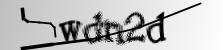

In [160]:
imageList, codeList = getData(1)
x_data = map(imageToVertor, imageList)
y_data = map(codeToVertor, codeList)
p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})
print 'code:', codeList[0]
print 'prediction:', map(lambda x: charset[x], p[0])
print 'loss:', l
imageList[0]

#### (2). 实际测试

In [ ]:
# url = 'https://s.nacao.org.cn/servlet/ValidateCode?time='
# response = requests.get(url)
# image = Image.open(StringIO(response.content))
# imageList, codeList = [image], ['ca358']
# x_data = map(imageToVertor, imageList)
# y_data = map(codeToVertor, codeList)
# p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})
# print 'prediction:', map(lambda x: charset[x], p[0])
# print 'loss:', l
# image

prediction: ['8']


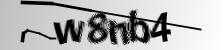

In [172]:
url = 'https://s.nacao.org.cn/servlet/ValidateCode?time='
response = requests.get(url)
image = Image.open(StringIO(response.content))
imageList = [image]
x_data = map(imageToVertor, imageList)
p = session.run(prediction, feed_dict={x: x_data, keep_prob: 1})
print 'prediction:', map(lambda x: charset[x], p[0])
image